# 1.7.3 Common Restaurants

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import textdistance
import string
import re
from collections import defaultdict

In [2]:
from research.strings import VIOLATIONS, MONTHS

## Monthly Average Temperature Data

In [3]:
df_canvass = pd.read_csv("data/canvass_records.csv.gz")
df_canvass["critical_found"] = df_canvass[VIOLATIONS].max(axis=1)
print("Read {} canvass records.".format(len(df_canvass)))

Read 50462 canvass records.


In [31]:
df_complaint = pd.read_csv("data/complaint_records.csv.gz")
df_complaint["critical_found"] = df_complaint[VIOLATIONS].max(axis=1)
print("Read {} complaint records.".format(len(df_complaint)))

Read 17088 complaint records.


In [4]:
df_weather = pd.read_csv("data/historical_weather.csv")
print("Read {} weather records.".format(len(df_weather)))

Read 108 weather records.


In [5]:
weather_dict = defaultdict(lambda: {})
for rec in df_weather.to_dict(orient="records"):
    weather_dict[rec["year"]][rec["month"]] = rec["temperature"]
print("Mapped {} weather records.".format(sum([len(d) for d in weather_dict.values()])))

Mapped 108 weather records.


In [6]:
temps = [weather_dict[d["year"]][d["month"]] for d in df_canvass[["year", "month"]].to_dict(orient="records")]
df_canvass["avg_temp"] = temps
mu = np.mean(temps)
sigma = np.std(temps)
df_canvass["z_temp"] = [(t - mu) / sigma for t in temps]
print("Mean Monthly Avg. Temp. = {0:.1f} F".format(mu))
print("Std. Monthly Avg. Temp. = {0:.1f} F".format(sigma))

Mean Monthly Avg. Temp. = 53.3 F
Std. Monthly Avg. Temp. = 17.9 F


In [32]:
temps = [weather_dict[d["year"]][d["month"]] for d in df_complaint[["year", "month"]].to_dict(orient="records")]
df_complaint["avg_temp"] = temps
mu = np.mean(temps)
sigma = np.std(temps)
df_complaint["z_temp"] = [(t - mu) / sigma for t in temps]
print("Mean Monthly Avg. Temp. = {0:.1f} F".format(mu))
print("Std. Monthly Avg. Temp. = {0:.1f} F".format(sigma))

Mean Monthly Avg. Temp. = 53.1 F
Std. Monthly Avg. Temp. = 18.2 F


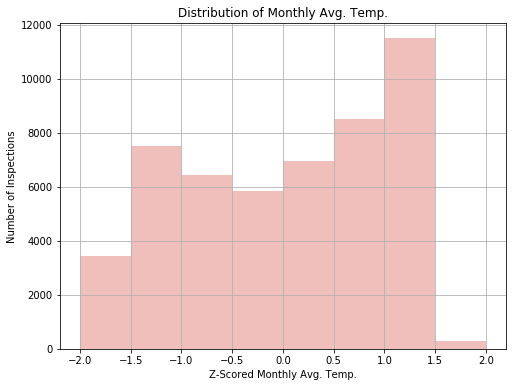

In [7]:
pal = sns.color_palette("hls", 1)
sns.distplot(df_canvass["z_temp"], kde=False, bins=np.arange(-2.0, 2.5, 0.5), color=pal[0])
plt.title("Distribution of Monthly Avg. Temp.")
plt.xlabel("Z-Scored Monthly Avg. Temp.")
plt.ylabel("Number of Inspections")
plt.grid()
plt.gcf().set_size_inches(8, 6)
plt.show()

## Names of Common Restaurants

In [8]:
def clean_name(original, backup, fallback="nullname"):
    name = fallback
    if not pd.isna(original):
        name = original
    elif not pd.isna(backup):
        name = backup
    clean = name.casefold()
    for p in list(string.punctuation):
        clean = clean.replace(p, "")
    clean = clean.replace(" ", "_")
    return clean

In [9]:
name_opts = df_canvass[["aka_name", "dba_name"]].to_dict(orient="records")
df_canvass["clean_name"] = [clean_name(n["aka_name"], n["dba_name"]) for n in name_opts]

In [10]:
name_labels_dict = defaultdict(lambda: [])
label_names_dict = defaultdict(lambda: [])
rest_names = []
with open("models/names/all_names.txt", "r") as all_names_file:
    rest_names = [re.sub("\.txt$", "", f) for f in all_names_file.read().split()]
    for rest_name in rest_names:
        with open("models/names/" + rest_name + ".txt", "r") as name_file:
            all_names = [re.sub("\.txt$", "", f) for f in name_file.read().split()]
            for name in all_names:
                name_labels_dict[name].append(rest_name)
                label_names_dict[rest_name].append(name)
for rest_name in label_names_dict:
    label_names_dict[rest_name] = np.unique(label_names_dict[rest_name])
print("Read {} name clusters.".format(len(rest_names)))
print("Mapped {} unique labels.".format(len(label_names_dict)))
print("Mapped {} unique names.".format(len(name_labels_dict)))

Read 51 name clusters.
Mapped 51 unique labels.
Mapped 458 unique names.


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [12]:
mlb = MultiLabelBinarizer()
all_rest_labels = df_canvass["clean_name"].apply(lambda n: name_labels_dict[n])
all_rest_vecs = mlb.fit_transform(all_rest_labels)

In [13]:
in_top_rests = all_rest_vecs.max(axis=1)
rest_vecs = all_rest_vecs[in_top_rests.astype(bool)]
df_rests = df_canvass[in_top_rests.astype(bool)]
print("Found {} inspections included in name clusters.".format(sum(in_top_rests)))
print("Filtered {} vectors.".format(len(rest_vecs)))
print("Filtered {} rows.".format(len(df_rests)))

Found 8783 inspections included in name clusters.
Filtered 8783 vectors.
Filtered 8783 rows.


In [14]:
df_labels = pd.DataFrame([(c, np.sum([
    len(df_rests.query("clean_name == '{}'".format(n))) for n in a
])) for c, a in label_names_dict.items()], columns=["restaurant", "inspections"])
df_labels.sort_values(by="inspections", ascending=False).head(10)

,restaurant,inspections
42,subway,2102
13,dunkin_donuts,961
41,starbucks,857
26,mcdonalds,433
35,potbelly,386
5,baskin_robbins,355
21,jimmy_johns,343
9,chipotle,215
34,popeyes,192
22,kfc,157


## Logistic Regression Weights

In [15]:
xdf = pd.DataFrame(rest_vecs, columns=mlb.classes_)
xdf.insert(loc=0, column="z_temp", value=df_rests["z_temp"].values)
columns = xdf.columns
X = xdf.values
xdf.head()

,z_temp,afc_sushi,als_beef,arbys,argo_tea,au_bon_pain,baskin_robbins,burger_king,burrito_beach,caffe_baci,...,starbucks,subway,taco__burrito_house,taco_bell,taco_burrito_king,taco_fresco,tokyo_lunch_box,wendys,wingstop,wow_bao
0,-1.187176,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.930565,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.986295,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.707645,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.376405,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [16]:
def get_weights_grid_search(df_rests, X, n_cv=5):
    best_weights = []
    viol_counts = df_rests[VIOLATIONS].values.sum(axis=0)
    for viol, viol_count in zip(VIOLATIONS, viol_counts):
        print("Searching {}: ({} samples)...".format(viol, viol_count))
        if viol_count > n_cv:
            logit = LogisticRegression(solver="liblinear", penalty="l1")
            parameters = {"C": np.logspace(-2, 10, 13)}
            gs = GridSearchCV(logit, parameters, cv=n_cv, return_train_score=False)
            gs.fit(X, df_rests[viol].values)
            print("\tBest Score: {0:.3f}".format(gs.best_score_))
            clf = gs.best_estimator_
            print("\tBest C: {}".format(gs.best_params_["C"]))
            best_weights.append((viol, clf.coef_[0], clf.intercept_[0]))
        else:
            print("\tNot enough samples.")
    return best_weights

In [17]:
def get_weights_simple(df_rests, X):
    simple_weights = []
    viol_counts = df_rests[VIOLATIONS].values.sum(axis=0)
    for viol, viol_count in zip(VIOLATIONS, viol_counts):
        print("Searching {}: ({} samples)...".format(viol, viol_count))
        if viol_count > 0:
            clf = LogisticRegression(solver="liblinear", max_iter=1000)
            clf.fit(X, df_rests[viol].values)
            simple_weights.append((viol, clf.coef_[0], clf.intercept_[0]))
        else:
            print("\tNot enough samples.")
    return simple_weights

In [18]:
def get_nonzero_weights(rdf, weights):
    return rdf[[not b for b in np.isclose(abs(rdf[[v for v, _, _ in weights]].max(axis=1)), 0)]]

In [19]:
def get_weight_matrix(weight_list, columns):
    data = {
        "features": ["intercept"] + list(columns)
    }
    for v, coef, intercept in weight_list:
        data[v] = [intercept] + list(coef)
    mdf = pd.DataFrame(data)
    return mdf

In [20]:
def get_weight_table(weight_list, columns):
    rows = []
    for v, coef, intercept in weight_list:
        rows.append({
            "violation": v,
            "feature": "intercept",
            "weight": intercept
        })
        for weight, col in zip(coef, columns):
            rows.append({
                "violation": v,
                "feature": col,
                "weight": weight
            })
    return pd.DataFrame(rows)

In [21]:
def show_top_features(wtd, k_top, ascending):
    gp = wtd.groupby("violation")[["weight", "feature"]]
    tf = gp.apply(lambda m: m.sort_values(by="weight", ascending=ascending).head(k_top))
    return tf.T[filter(lambda v: v in tf.index, VIOLATIONS)].T

In [22]:
# best_weights = get_weights_grid_search(df_rests, X, n_cv=5)
# gdf = get_weight_matrix(best_weights, columns)

In [23]:
# get_nonzero_weights(gdf, best_weights)

In [24]:
simple_weights = get_weights_simple(df_rests, X)
sdf = get_weight_matrix(simple_weights, columns)

Searching V1: (3 samples)...
Searching V2: (321 samples)...
Searching V3: (614 samples)...
Searching V4: (22 samples)...
Searching V5: (0 samples)...
	Not enough samples.
Searching V6: (131 samples)...
Searching V7: (8 samples)...
Searching V8: (84 samples)...
Searching V9: (75 samples)...
Searching V10: (34 samples)...
Searching V11: (171 samples)...
Searching V12: (131 samples)...
Searching V13: (2 samples)...
Searching V14: (8 samples)...


In [29]:
sdf.head(10).T

,0,1,2,3,4,5,6,7,8,9
features,intercept,z_temp,afc_sushi,als_beef,arbys,argo_tea,au_bon_pain,baskin_robbins,burger_king,burrito_beach
V1,-6.48525,-0.295157,-0.137879,-0.0888938,-0.0590067,-0.136611,-0.200662,-0.234529,-0.181473,-0.0931589
V2,-3.3335,0.293454,-0.716409,-0.383205,0.218143,0.856354,0.663904,-0.49321,-1.01626,0.781417
V3,-2.5066,0.201419,-0.527172,-0.302283,-0.31118,0.683553,0.531291,-0.241426,-1.30239,0.937392
V4,-5.5977,-0.000239933,-0.275107,0.603005,-0.129746,-0.281672,0.284341,-0.341086,-0.36833,-0.184364
V6,-4.32255,-0.0874538,-0.133736,0.593989,-0.364813,-0.144399,0.0174188,0.705861,-0.823482,0.106455
V7,-6.21705,0.084507,-0.165258,-0.104757,-0.0744787,-0.17084,-0.228722,-0.371514,0.512627,-0.105793
V8,-4.3646,0.0607585,-0.647302,-0.464441,-0.355125,1.65712,0.0639898,-0.0807271,0.058577,-0.468388
V9,-4.70881,-0.0900998,-0.524565,-0.370911,-0.272591,0.50957,-0.148766,0.279927,-0.659656,-0.377755
V10,-5.46728,-0.0159909,0.391164,-0.203131,-0.145368,-0.311239,-0.409455,-0.587647,-0.403775,-0.206216


In [25]:
wtd = get_weight_table(simple_weights, columns).query("feature != 'intercept'")

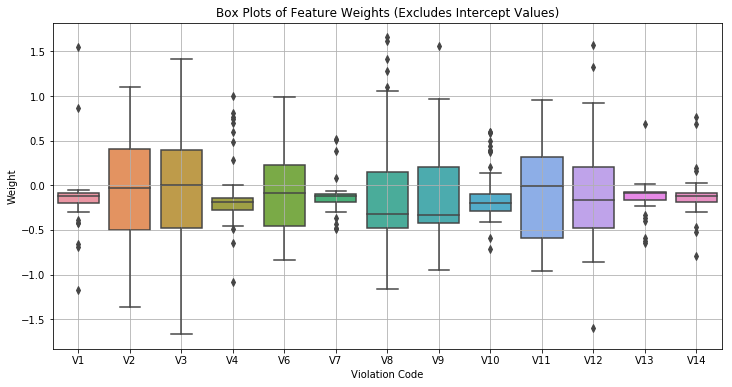

In [26]:
sns.boxplot(x="violation", y="weight", data=wtd)
plt.xlabel("Violation Code")
plt.ylabel("Weight")
plt.title("Box Plots of Feature Weights (Excludes Intercept Values)")
plt.grid()
plt.gcf().set_size_inches(12, 6)
plt.show()

In [27]:
show_top_features(wtd, 3, ascending=False)

weight                feature
violation                                      
V1        25     1.54996       las_islas_marias
          17    0.868882            epic_burger
          45  -0.0564519    taco__burrito_house
V2        73     1.09973    halsted_street_deli
          58    0.856354               argo_tea
          71    0.805824                freshii
V3        126    1.41479    halsted_street_deli
          116    1.02368             caffe_baci
          151    1.01542    taco__burrito_house
V4        177    1.00144                freshii
          196   0.810006               potbelly
          183   0.767407                    kfc
V6        235   0.992051            jimmy_johns
          237   0.992042       las_islas_marias
          261   0.975483        tokyo_lunch_box
V7        293   0.521588              mcdonalds
          273   0.512627            burger_king
          276    0.38428               chipotle
V8        323    1.65712               argo_tea
          343    1.61249       las_islas_marias
          344    1.41079  lou_malnatis_pizzeria
V9        416    1.55813    taco__burrito_house
          422   0.969994               wingstop
          396   0.825863       las_islas_marias
V10       464   0.597461      sarpinos_pizzeria
          465   0.595174                sbarros
          456   0.581835       papa_johns_pizza
V11       480   0.952418               als_beef
          483    0.89105            au_bon_pain
          501   0.838815                    kfc
V12       547    1.57377            epic_burger
          550    1.32848    halsted_street_deli
          562   0.924053       papa_johns_pizza
V13       597   0.685748          dominos_pizza
          584  0.0121856                 z_temp
          628 -0.0442249    taco__burrito_house
V14       676   0.769125      sarpinos_pizzeria
          670   0.688615              pizza_hut
          659    0.19468            jimmy_johns

In [28]:
show_top_features(wtd, 3, ascending=True)

weight             feature
violation                                  
V1        44   -1.16875              subway
          15  -0.689734       dunkin_donuts
          43  -0.663002           starbucks
V2        96   -1.36956           starbucks
          104  -1.02972            wingstop
          61   -1.01626         burger_king
V3        149  -1.66638           starbucks
          152  -1.33054           taco_bell
          114  -1.30239         burger_king
V4        174  -1.08208       dunkin_donuts
          202 -0.651885           starbucks
          170 -0.488069            chipotle
V6        255 -0.836691           starbucks
          220 -0.823482         burger_king
          258  -0.72308           taco_bell
V7        309 -0.490401              subway
          302 -0.475001            potbelly
          288 -0.438141         jimmy_johns
V8        362  -1.16073              subway
          342 -0.847966                 kfc
          330    -0.799  corner_bakery_cafe
V9        414 -0.947664           starbucks
          401 -0.665009       panda_express
          379 -0.659656         burger_king
V10       447 -0.711105         jimmy_johns
          431 -0.587647      baskin_robbins
          430 -0.409455         au_bon_pain
V11       523 -0.956863           taco_bell
          496 -0.926891     giordanos_pizza
          488  -0.87029            chipotle
V12       573  -1.60042           starbucks
          542 -0.862703  corner_bakery_cafe
          560 -0.841609       panda_express
V13       598 -0.643509       dunkin_donuts
          626 -0.626772           starbucks
          627 -0.587638              subway
V14       651 -0.796918       dunkin_donuts
          664 -0.521126           mcdonalds
          673 -0.467573            potbelly

## Mutual Information

In [39]:
from sklearn.feature_selection import mutual_info_classif

In [40]:
discrete_idx = list(range(1, len(columns)))

In [41]:
mi_res = []
for viol in VIOLATIONS:
    mi = mutual_info_classif(X, df_rests[viol].values, discrete_features=discrete_idx, random_state=0)
    mi_res.append(mi)
mi_mat = np.array(mi_res).T

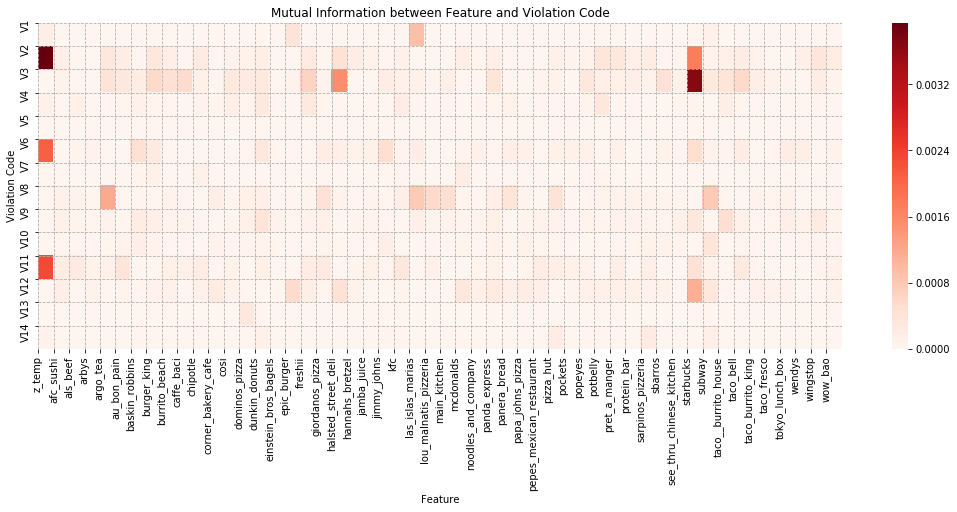

In [42]:
sns.heatmap(mi_mat.T, cmap="Reds")
plt.xticks(range(len(columns)), columns, rotation="vertical")
plt.yticks(range(len(VIOLATIONS)), VIOLATIONS)
plt.xlabel("Feature")
plt.ylabel("Violation Code")
plt.title("Mutual Information between Feature and Violation Code")
plt.grid(linestyle="--")
plt.gcf().set_size_inches(18, 6)
plt.show()

In [43]:
all_temp = df_canvass["z_temp"].values.reshape(-1, 1)
all_temp_mis = np.array([
    mutual_info_classif(all_temp, df_canvass[viol].values, discrete_features=False, random_state=0)
    for viol in VIOLATIONS
])

In [44]:
vmi_df = pd.DataFrame({
    "violation": VIOLATIONS,
    "mutual_info": all_temp_mis.reshape(len(VIOLATIONS))
})
vmi_df.sort_values(by="mutual_info", ascending=False)

,violation,mutual_info
1,V2,0.004523
2,V3,0.004188
5,V6,0.002108
10,V11,0.001264
3,V4,0.001181
0,V1,0.001037
7,V8,0.000691
9,V10,0.000558
12,V13,0.000457
6,V7,0.000417


In [45]:
def show_vi_mi(df):
    all_temp = df["z_temp"].values.reshape(-1, 1)
    all_temp_mis = np.array([
        mutual_info_classif(all_temp, df[viol].values, discrete_features=False, random_state=0)
        for viol in VIOLATIONS
    ])
    vmi_df = pd.DataFrame({
        "violation": VIOLATIONS,
        "mutual_info": all_temp_mis.reshape(len(VIOLATIONS))
    })
    return vmi_df

In [46]:
vmi_df_complaint = show_vi_mi(df_complaint)
vmi_df_complaint["canvass_mi"] = vmi_df["mutual_info"].values
vmi_df_complaint.sort_values(by="mutual_info", ascending=False)

,violation,mutual_info,canvass_mi
1,V2,0.005826,0.004523
2,V3,0.004977,0.004188
3,V4,0.002198,0.001181
7,V8,0.001168,0.000691
9,V10,0.001101,0.000558
5,V6,0.001046,0.002108
6,V7,0.000562,0.000417
10,V11,0.000418,0.001264
13,V14,0.000404,0.000259
0,V1,0.000207,0.001037


## Relative Risk

In [35]:
def relative_risk(a, b, c, d):
    """
    Computes relative risk:
        RR = (a  / (a + b)) / (c / (c + d))
    parameters:
        a = # of cases exposed and affected
        b = # of cases exposed and not affected
        c = # of cases not exposed and affected
        d = # of cases not exposed and not affected
    returns:
        float: relative risk (or None if undefined)
    
    >>> table = (1, 0, 8, 12)
    >>> relative_risk(*table)
    2.5
    >>> table = (0, 0, 0, 0)
    >>> relative_risk(*table)
    None
    """
    undef = None
    exposed = a + b
    not_exposed = c + d
    if exposed == 0:
        return undef
    if not_exposed == 0:
        return None
    if c == 0:
        return undef
    num = a / (a + b)
    den = c / (c + d)
    return num / den

In [36]:
def fishers_exact_p(a, b, c, d):
    """
    Computes p-value for relative risk by Fisher's Exact Test:
        p = ((a + b)!(c + d)!(a + c)!(b + d)!) / (a!b!c!d!(a + b + c + d)!)
    parameters:
        a = # of cases exposed and affected
        b = # of cases exposed and not affected
        c = # of cases not exposed and affected
        d = # of cases not exposed and not affected
    returns:
        float: p-value for relative risk (or None if undefined)

    >>> table = (1, 0, 8, 12)
    >>> fishers_exact_p(*table)
    0.42857142857142855
    >>> table = (0, 0, 0, 0)
    >>> fishers_exact_p(*table)
    1.0
    """
    undef = None
    abf = math.factorial(a + b)
    cdf = math.factorial(c + d)
    acf = math.factorial(a + c)
    bdf = math.factorial(b + d)
    num = abf * cdf * acf * bdf
    if num == 0:
        return 0
    n = a + b + c + d
    af = math.factorial(a)
    bf = math.factorial(b)
    cf = math.factorial(c)
    df = math.factorial(d)
    nf = math.factorial(n)
    den = af * bf * cf * df * nf
    if den == 0:
        return undef
    return num / den

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
rr_recs = []
for viol in VIOLATIONS:
    for feat_idx, feat in list(enumerate(columns))[1:]:
        y_viol = df_rests[viol].values
        X_feat = X[:,feat_idx].astype(int)
        cm = confusion_matrix(y_viol, X_feat)
        d, b, c, a = cm.flatten()
        table = a, b, c, d
        rec = {
            "feature": feat,
            "violation": viol,
            "a": a,
            "b": b,
            "c": c,
            "d": d,
            "rr": relative_risk(*table),
            "p": fishers_exact_p(*table)
        }
        rr_recs.append(rec)
meta = ["feature", "violation", "a", "b", "c", "d", "rr", "p"]
rr_df = pd.DataFrame(rr_recs)
rr_df = rr_df[meta]

In [39]:
def rr_to_factor(rr):
    if pd.isnull(rr):
        return rr
    if rr == 0:
        return None
    if rr < 1:
        return -1 * (rr**-1)
    elif rr > 1:
        return rr
    else:
        return 0

    
def rr_to_factor_norm(rr, max_rr, min_rr):
    if pd.isnull(rr):
        return rr
    if rr == 0:
        return None
    if rr < 1:
        return -1 * (rr / min_rr)
    elif rr > 1:
        return rr / max_rr
    else:
        return 0

In [40]:
rr_dict = defaultdict(lambda: defaultdict(lambda: {}))
for rec in rr_recs:
    rr = rec["rr"]
    if not pd.isnull(rr) and rr > 0:
        rr = max(min(rr, 10), 0.1)
    rr_dict[rec["violation"]][rec["feature"]] = rr

In [41]:
rr_mat = [[rr_dict[v][c] for c in columns[1:]] for v in VIOLATIONS]
rr_fac_mat = [[rr_to_factor(rr) for rr in row] for row in rr_mat]
min_rr = pd.DataFrame(np.array(rr_fac_mat).flatten()).dropna().min()[0]
max_rr = pd.DataFrame(np.array(rr_fac_mat).flatten()).dropna().max()[0]
rr_fac_norm_mat = [[rr_to_factor_norm(rr, max_rr, min_rr) for rr in row] for row in rr_fac_mat]
rr_mat_df = pd.DataFrame(rr_fac_norm_mat).fillna(np.nan)

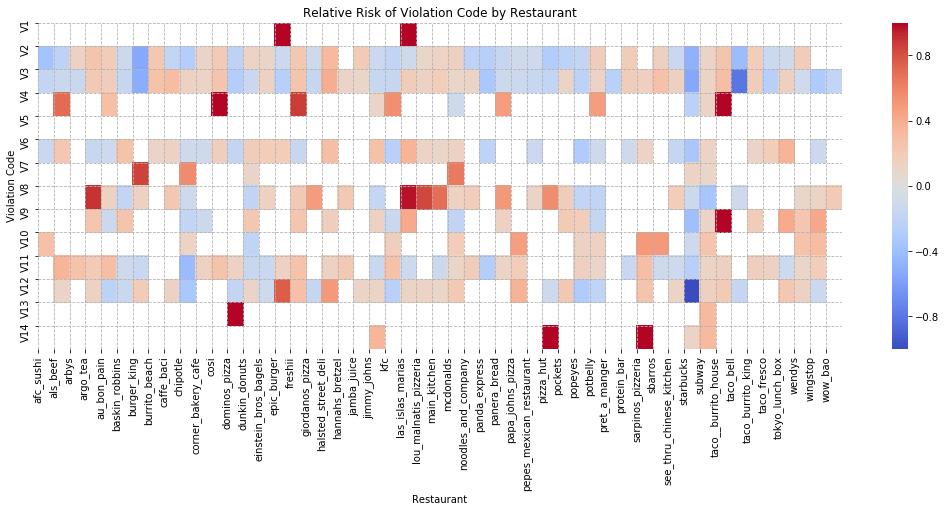

In [42]:
sns.heatmap(rr_mat_df.values, cmap="coolwarm", mask=rr_mat_df.isnull())
plt.xticks(range(len(columns[1:])), columns[1:], rotation="vertical")
plt.yticks(range(len(VIOLATIONS)), VIOLATIONS)
plt.xlabel("Restaurant")
plt.ylabel("Violation Code")
plt.title("Relative Risk of Violation Code by Restaurant")
plt.grid(linestyle="--")
plt.gcf().set_size_inches(18, 6)
plt.show()

In [43]:
rr_df.sort_values(by=["rr"], ascending=False).head(10).round(3)

,feature,violation,a,b,c,d,rr,p
23,las_islas_marias,V1,2,55,1,8725,306.175,0.000
15,epic_burger,V1,1,35,2,8745,121.486,0.012
624,dominos_pizza,V13,1,115,1,8666,74.716,0.026
701,sarpinos_pizzeria,V14,1,52,7,8723,23.531,0.046
695,pizza_hut,V14,1,77,7,8698,15.943,0.067
196,taco__burrito_house,V4,1,33,21,8728,12.254,0.079
451,taco__burrito_house,V9,3,31,72,8677,10.722,0.003
164,cosi,V4,1,39,21,8722,10.408,0.091
380,las_islas_marias,V8,5,52,79,8647,9.689,0.000
360,argo_tea,V8,8,93,76,8606,9.048,0.000


In [44]:
rr_df.sort_values(by=["a"], ascending=False).head(10).round(3)

,feature,violation,a,b,c,d,rr,p
144,subway,V3,170,1932,444,6237,1.217,0.003
93,subway,V2,85,2017,236,6445,1.145,0.029
115,dunkin_donuts,V3,51,910,563,7259,0.737,0.005
552,subway,V11,48,2054,123,6558,1.240,0.031
64,dunkin_donuts,V2,45,916,276,7546,1.327,0.015
603,subway,V12,43,2059,88,6593,1.553,0.005
297,subway,V6,37,2065,94,6587,1.251,0.040
137,potbelly,V3,35,351,579,7818,1.315,0.021
128,mcdonalds,V3,31,402,583,7767,1.025,0.075
86,potbelly,V2,24,362,297,8100,1.758,0.004


In [45]:
rr_gp = rr_df.groupby("violation")[["feature", "rr", "p", "a", "b", "c", "d"]]
rr_gp.apply(lambda m: m.sort_values(by="rr", ascending=False).head(3).round(3)).T[VIOLATIONS].T

feature       rr      p   a     b    c     d
violation                                                                
V1        23        las_islas_marias  306.175      0   2    55    1  8725
          15             epic_burger  121.486  0.012   1    35    2  8745
          0                afc_sushi        0  0.967   0    98    3  8682
V2        69     halsted_street_deli    3.181  0.003   8    62  313  8400
          54                argo_tea     2.48  0.008   9    92  312  8370
          94     taco__burrito_house    2.428  0.092   3    31  318  8431
V3        120    halsted_street_deli    3.975      0  19    51  595  8118
          110             caffe_baci    3.013  0.001  10    38  604  8131
          145    taco__burrito_house    2.967  0.006   7    27  607  8142
V4        196    taco__burrito_house   12.254  0.079   1    33   21  8728
          164                   cosi   10.408  0.091   1    39   21  8722
          169                freshii    8.683  0.024   2    98   20  8663
V5        204              afc_sushi      NaN      1   0    98    0  8685
          205               als_beef      NaN      1   0    59    0  8724
          206                  arbys      NaN      1   0    40    0  8743
V6        278       las_islas_marias    3.588  0.043   3    54  128  8598
          302        tokyo_lunch_box    3.526  0.045   3    55  128  8597
          273    halsted_street_deli    2.917  0.066   3    67  128  8585
V7        312            burger_king     8.57  0.117   1   143    7  8632
          332              mcdonalds    6.428   0.05   2   431    6  8344
          315               chipotle    5.693  0.165   1   214    7  8561
V8        380       las_islas_marias    9.689      0   5    52   79  8647
          360               argo_tea    9.048      0   8    93   76  8606
          381  lou_malnatis_pizzeria    8.395  0.001   4    48   80  8651
V9        451    taco__burrito_house   10.722  0.003   3    31   72  8677
          457               wingstop    4.264   0.03   3    82   72  8626
          431       las_islas_marias    4.194  0.072   2    55   73  8653
V10       497      sarpinos_pizzeria    4.991  0.169   1    52   33  8697
          498                sbarros    4.991  0.169   1    52   33  8697
          489       papa_johns_pizza    4.722  0.176   1    55   33  8694
V11       511               als_beef    3.542  0.022   4    55  167  8557
          548      sarpinos_pizzeria    2.941  0.064   3    50  168  8562
          514            au_bon_pain    2.903  0.005   8   138  163  8474
V12       576            epic_burger    7.653  0.002   4    32  127  8620
          579    halsted_street_deli    4.939  0.003   5    65  126  8587
          591       papa_johns_pizza    3.652  0.041   3    53  128  8599
V13       624          dominos_pizza   74.716  0.026   1   115    1  8666
          654                 subway    3.178  0.364   1  2101    1  6680
          612              afc_sushi        0  0.978   0    98    2  8683
V14       701      sarpinos_pizzeria   23.531  0.046   1    52    7  8723
          695              pizza_hut   15.943  0.067   1    77    7  8698
          684            jimmy_johns    3.515  0.237   1   342    7  8433